In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from itertools import product # itertools would speed up the loops
from scipy.stats import poisson 

from tqdm import trange

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
# Setting up the environment variables

# maximum # of cars in each location
MAX_CARS = 20

# maximum # of cars to move during night
MAX_MOVE_OF_CARS = 5

# expectation for rental requests in first location
E_RENTAL_REQUEST_FIRST_LOC = 3

# expectation for rental requests in second location
E_RENTAL_REQUEST_SECOND_LOC = 4

# expectation for # of cars returned in first location
E_RETURNS_FIRST_LOC = 3

# expectation for # of cars returned in second location
E_RETURNS_SECOND_LOC = 2

# discount raio is set at 0.9
DISCOUNT = 0.9

# credit earned by a car
RENTAL_CREDIT = 10

# cost of moving a car
MOVE_CAR_COST = 2

# action space: positive number means moving cars from first location to second location and vice versa
ACTION_SPACE = np.arange(-MAX_MOVE_OF_CARS, MAX_MOVE_OF_CARS + 1)

# An up bound for poisson distribution
# If n is greater than this value, then the probability of getting n is truncated to 0 (avoid unnecessary calculation)
POISSON_UPPER_BOUND = 11

# Probability for poisson distribution
# Pre-calculate all the pmf for poisson distribution to avoid repetitive computation.
P = dict()

for n in range(POISSON_UPPER_BOUND):
    for lam in [E_RENTAL_REQUEST_FIRST_LOC, E_RENTAL_REQUEST_SECOND_LOC, E_RETURNS_FIRST_LOC, E_RETURNS_SECOND_LOC]:
        P[(n, lam)] = poisson.pmf(n, lam)

In [3]:
def expected_return(state, action, state_value, constant_returned_cars):
    """
    This function calculates the expected return of a current state based on
    the current state-value function and the current policy.

    @state: [# of cars in first location, # of cars in second location]
    @action: positive if moving cars from first location to second location,
            negative if moving cars from second location to first location
    @stateValue: state value matrix
    @constant_returned_cars:  if set True, model is simplified such that
    the # of cars returned in daytime becomes constant
    rather than a random value from poisson distribution, which will reduce calculation time
    and leave the optimal policy/value state matrix almost the same
    """
    # initailize total return
    returns = 0.0

    # cost for moving cars
    returns -= MOVE_CAR_COST * abs(action)

    # moving cars
    NUM_OF_CARS_FIRST_LOC = min(state[0] - action, MAX_CARS)
    NUM_OF_CARS_SECOND_LOC = min(state[1] + action, MAX_CARS)

    # go through all possible rental requests
    for rental_request_first_loc, rental_request_second_loc in product(range(POISSON_UPPER_BOUND), repeat=2):
        # probability for current combination of rental requests
        prob_request = P[(rental_request_first_loc, E_RENTAL_REQUEST_FIRST_LOC)] * P[(rental_request_second_loc, E_RENTAL_REQUEST_SECOND_LOC)]

        num_of_cars_first_loc = NUM_OF_CARS_FIRST_LOC
        num_of_cars_second_loc = NUM_OF_CARS_SECOND_LOC

        # valid rental requests should be less than actual # of cars
        valid_rental_first_loc = min(num_of_cars_first_loc, rental_request_first_loc)
        valid_rental_second_loc = min(num_of_cars_second_loc, rental_request_second_loc)

        # get credits for renting
        reward = (valid_rental_first_loc + valid_rental_second_loc) * RENTAL_CREDIT
        num_of_cars_first_loc -= valid_rental_first_loc
        num_of_cars_second_loc -= valid_rental_second_loc

        if constant_returned_cars:
            # get returned cars, those cars can be used for renting tomorrow
            returned_cars_first_loc = E_RETURNS_FIRST_LOC
            returned_cars_second_loc = E_RETURNS_SECOND_LOC
            num_of_cars_first_loc = min(num_of_cars_first_loc + returned_cars_first_loc, MAX_CARS)
            num_of_cars_second_loc = min(num_of_cars_second_loc + returned_cars_second_loc, MAX_CARS)
            returns += prob_request * (reward + DISCOUNT * state_value[num_of_cars_first_loc, num_of_cars_second_loc])
        else:
            for returned_cars_first_loc, returned_cars_second_loc in product(range(POISSON_UPPER_BOUND), repeat=2):
                prob_return = P[(returned_cars_first_loc, E_RETURNS_FIRST_LOC)] * \
                    P[(returned_cars_second_loc, E_RETURNS_SECOND_LOC)]
                num_of_cars_first_loc_ = min(num_of_cars_first_loc + returned_cars_first_loc, MAX_CARS)
                num_of_cars_second_loc_ = min(num_of_cars_second_loc + returned_cars_second_loc, MAX_CARS)
                returns += (prob_return * prob_request) * (reward + DISCOUNT * state_value[num_of_cars_first_loc_, num_of_cars_second_loc_])
    return returns

def single_policy_iteration(value, policy, constant_returned_cars=True):
    """
    @value: state value matrix
    @policy: current policy
    @constant_returned_cars:  if set True, model is simplified such that
    the # of cars returned in daytime becomes constant
    rather than a random value from poisson distribution, which will reduce calculation time
    """
    # policy evaluation (in-place)
    while True:
        old_value = value.copy()
        for i, j in product(range(MAX_CARS + 1), repeat=2):
            new_state_value = expected_return([i, j], policy[i, j], value, constant_returned_cars)
            value[i, j] = new_state_value
        max_value_change = abs(old_value - value).max()
        print('max value change {}'.format(max_value_change))
        if max_value_change < 1e-4:
            break

    # policy improvement
    policy_stable = True
    for i, j in product(range(MAX_CARS + 1), repeat=2):
        old_action = policy[i, j]
        action_returns = []
        for action in ACTION_SPACE:
            if -j <= action <= i:
                action_returns.append(expected_return([i, j], action, value, constant_returned_cars))
            else:
                action_returns.append(-np.inf)
        new_action = ACTION_SPACE[np.argmax(action_returns)]
        policy[i, j] = new_action
        if policy_stable and old_action != new_action:
            policy_stable = False
    return value, policy, policy_stable

def value_iteration(value, constant_returned_cars=True):
    """
    @value: state value matrix
    @constant_returned_cars:  if set True, model is simplified such that
    the # of cars returned in daytime becomes constant
    rather than a random value from poisson distribution, which will reduce calculation time
    """
    while True:
        old_value = value.copy()
        for i, j in product(range(MAX_CARS + 1), repeat=2):
            valid_action_returns = []
            # NOTE: This following for loop can possibly be parallelized / vectorized to save time
            for action in np.arange(-j, i + 1):
                valid_action_returns.append(expected_return([i, j], action, value, constant_returned_cars))
            value[i, j] = max(valid_action_returns)
        max_value_change = abs(old_value - value).max()
        print('max value change {}'.format(max_value_change))
        if max_value_change < 1e-4:
            break
    
    policy = np.zeros((MAX_CARS + 1, MAX_CARS + 1), dtype=int)
    for i, j in product(range(MAX_CARS + 1), repeat=2):
        action_returns = []
        for action in ACTION_SPACE:
            if -j <= action <= i:
                action_returns.append(expected_return([i, j], action, value, constant_returned_cars))
            else:
                action_returns.append(-np.inf)
        new_action = ACTION_SPACE[np.argmax(action_returns)]
        policy[i, j] = new_action
    
    return value, policy


max value change 191.14044425450055
max value change 131.91909180411542
max value change 88.61937127296514
max value change 66.27613430095826
max value change 52.30404034617686
max value change 40.50431282688453
max value change 31.571819689709855
max value change 25.009002907688057
max value change 20.776212359973954
max value change 17.373214856382333
max value change 14.489145965680734
max value change 12.054381189472622
max value change 10.005913044444071
max value change 8.288060588890005
max value change 6.851978596679828
max value change 5.654991085770007
max value change 4.659991030583512
max value change 3.8349060091838396
max value change 3.1521952447087074
max value change 2.588360954112318
max value change 2.1234741080097024
max value change 1.7407223622981292
max value change 1.4259887280390444
max value change 1.1674672474201202
max value change 0.9553189041116639
max value change 0.7813683111010619
max value change 0.638839739487878
max value change 0.5221297762513473
ma

KeyboardInterrupt: 

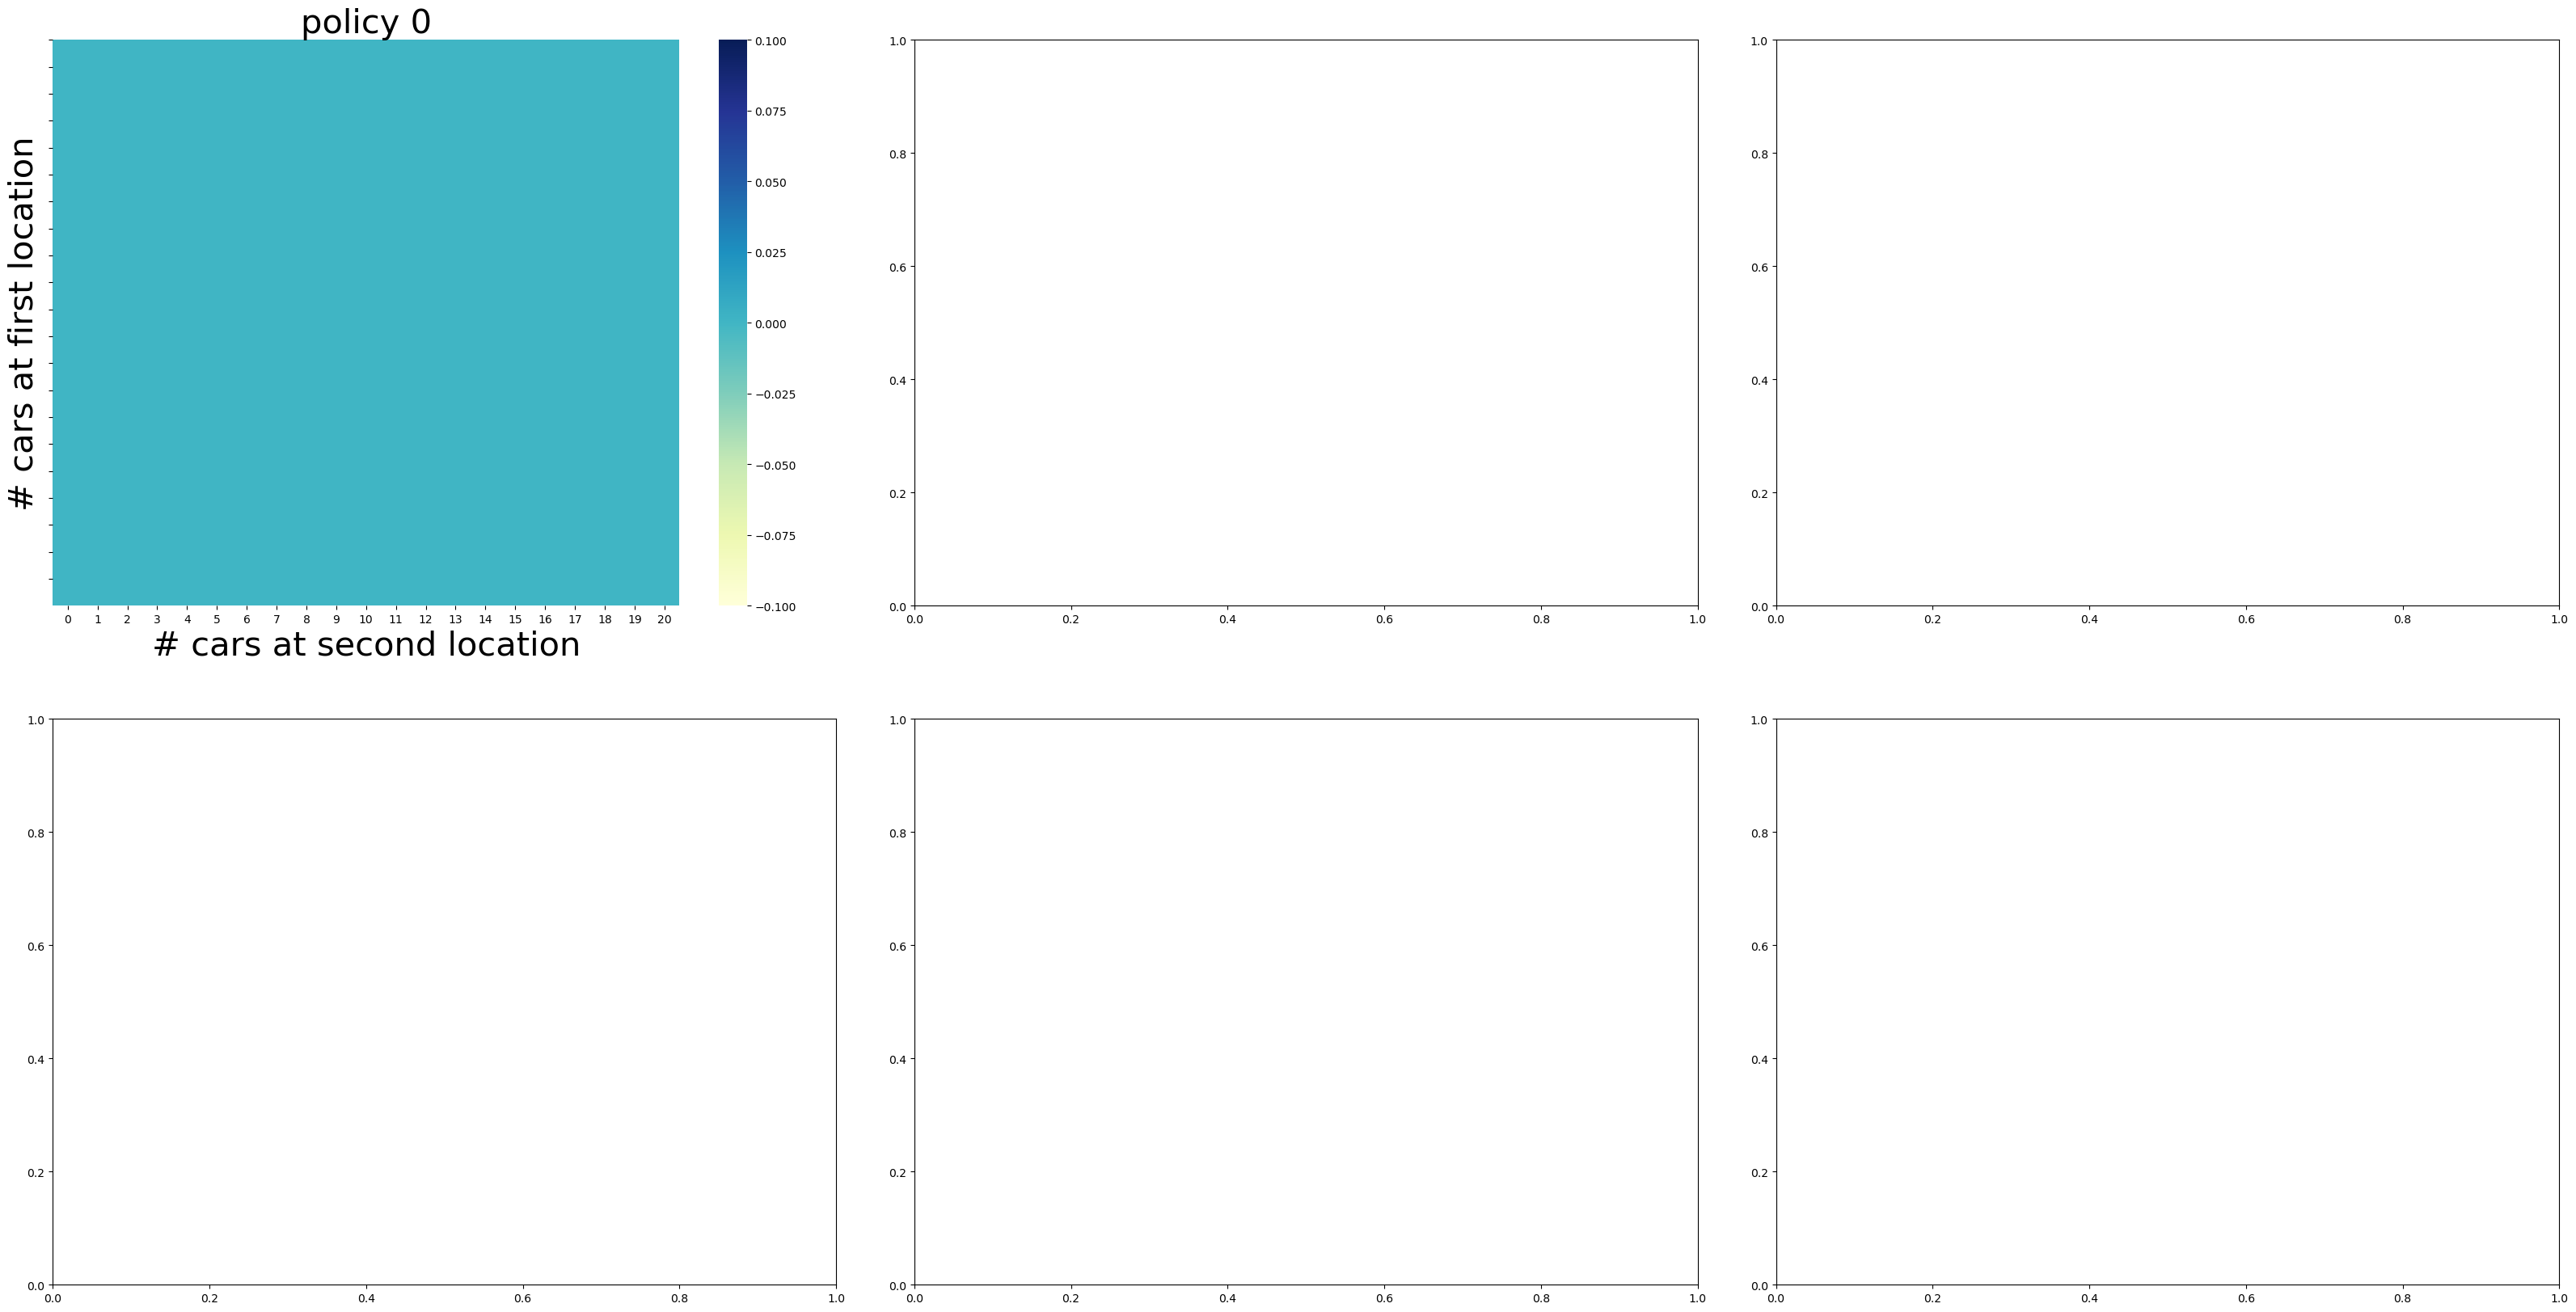

In [5]:
# Figure 4.2
value = np.zeros((MAX_CARS + 1, MAX_CARS + 1))
policy = np.zeros(value.shape, dtype=int)

iterations = 0
_, axes = plt.subplots(2, 3, figsize=(40, 20))
plt.subplots_adjust(wspace=0.1, hspace=0.2)
axes = axes.flatten()
while True:
    fig = sns.heatmap(np.flipud(policy), cmap="YlGnBu", ax=axes[iterations])
    fig.set_ylabel('# cars at first location', fontsize=30)
    fig.set_yticks(list(reversed(range(MAX_CARS + 1))))
    fig.set_xlabel('# cars at second location', fontsize=30)
    fig.set_title('policy {}'.format(iterations), fontsize=30)

    value, policy, policy_stable = single_policy_iteration(value, policy, constant_returned_cars=False)
    print('policy stable {}'.format(policy_stable))

    if policy_stable:
        fig = sns.heatmap(np.flipud(value), cmap="YlGnBu", ax=axes[-1])
        fig.set_ylabel('# cars at first location', fontsize=30)
        fig.set_yticks(list(reversed(range(MAX_CARS + 1))))
        fig.set_xlabel('# cars at second location', fontsize=30)
        fig.set_title('optimal value', fontsize=30)
        break

    iterations += 1

plt.show()

max value change 359.30214181303484
max value change 215.97858886008294
max value change 71.83651067418128
max value change 58.65883654308914
max value change 47.02970472082126
max value change 37.0975264154915
max value change 29.10778602630171
max value change 22.887911089204636
max value change 18.28932267163998
max value change 15.420055126646957
max value change 12.906820665725434
max value change 10.814874958654855
max value change 9.06818750233191
max value change 7.624142460073756
max value change 6.439206495093288
max value change 5.446679955103605
max value change 4.608141686376371
max value change 3.898559655233271
max value change 3.2980741316805506
max value change 2.7899887064776863
max value change 2.3601398642620097
max value change 1.996525149862066
max value change 1.6889530346605284
max value change 1.4287832124005035
max value change 1.208701113155314
max value change 1.0225240402000964
max value change 0.8650260024510885
max value change 0.7317881270139424
max valu

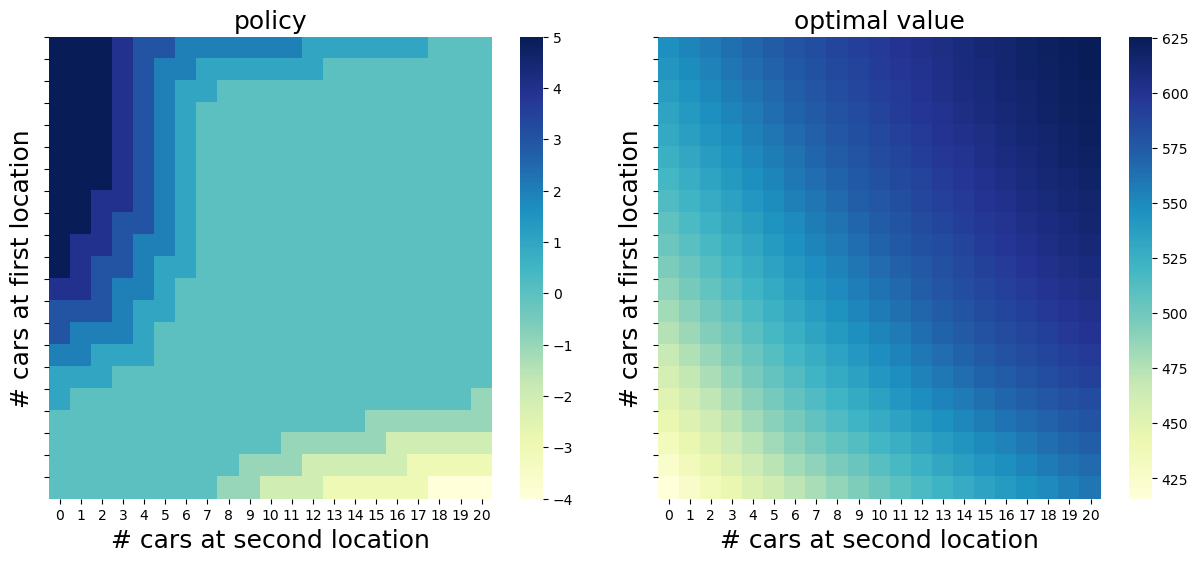

In [5]:
value = np.zeros((MAX_CARS + 1, MAX_CARS + 1))

_, axes = plt.subplots(1, 2, figsize=(15, 6))
plt.subplots_adjust(wspace=0.1, hspace=0.2)
axes = axes.flatten()

value, policy = value_iteration(value, constant_returned_cars=True)

fig = sns.heatmap(np.flipud(policy), cmap="YlGnBu", ax=axes[0])
fig.set_ylabel('# cars at first location', fontsize=18)
fig.set_yticks(list(reversed(range(MAX_CARS + 1))))
fig.set_xlabel('# cars at second location', fontsize=18)
fig.set_title('policy', fontsize=18)

fig = sns.heatmap(np.flipud(value), cmap="YlGnBu", ax=axes[-1])
fig.set_ylabel('# cars at first location', fontsize=18)
fig.set_yticks(list(reversed(range(MAX_CARS + 1))))
fig.set_xlabel('# cars at second location', fontsize=18)
fig.set_title('optimal value', fontsize=18)

plt.show()